# Solutions to Assignment 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe
from numba import njit
import jax
import jax.numpy as jnp
from scipy.stats import beta

In [2]:
jax.config.update("jax_enable_x64", True)

## Densities

In [21]:
def f_star(x):
    " Stationary density. "
    return 1 / (np.pi * np.sqrt(x * (1-x)))

In [22]:
def Pf(x):
    " Pf when f is uniform. "
    return (1/2) * 1 / np.sqrt(1-x)

In [23]:
def P2f(x):
    " P^2 f when f is uniform. "
    z = np.sqrt(1-x)
    return 1/(4 * z) * (Pf((1-z)/2) + Pf((1+z)/2))

## Trajectories and cross-sections

In [24]:
@njit
def g(x):
    return 4 * x * (1-x)

In [25]:
@njit
def gen_trajectory(x0, n=100):
    x = np.empty(n)
    x[0] = x0
    for t in range(n-1):
        x[t+1] = g(x[t])

    return x

In [26]:
@njit
def g_shifter(x0, n=20):
    " Shift x0 forward n periods. "
    x = x0
    for i in range(n):
        x = g(x)
    return x

## Plots

In [27]:
kwargs = dict(density=True, bins=150, alpha=0.5)
x_grid = np.linspace(0.0001, 0.9999, 200)

In [28]:
def plot_g():
    fig, ax = plt.subplots()
    xvec = np.linspace(0, 1, 100)
    ax.plot(xvec, [g(x) for x in xvec], label="$g(x)= 4x(1-x)$")
    ax.plot(xvec, xvec, 'k-', lw=0.5, label='45 degrees')
    ax.set_xticks((0, 1))
    ax.set_yticks((0, 1))
    ax.legend()
    plt.show()

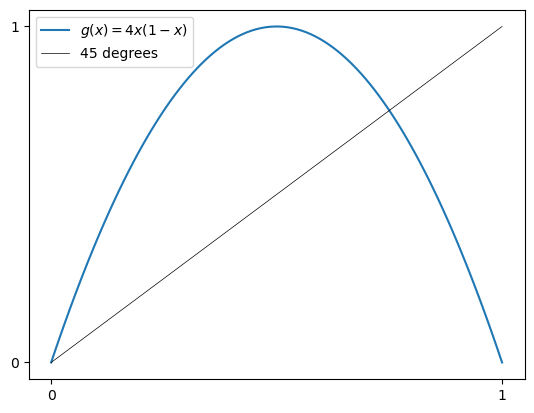

In [29]:
plot_g()

In [30]:
def plot_gn(n=20):
    fig, ax = plt.subplots()
    xvec = np.linspace(0, 1, 100)
    ax.plot(xvec, [g_shifter(x, n) for x in xvec], label="$g^n$")
    ax.set_xticks((0, 1))
    ax.set_yticks((0, 1))
    ax.set_xlabel("initial condition $x_0$", fontsize=14)
    ax.set_title(f"$g^n(x_0)$ when $n = {n}$", fontsize=14)
    ax.legend()
    plt.show()

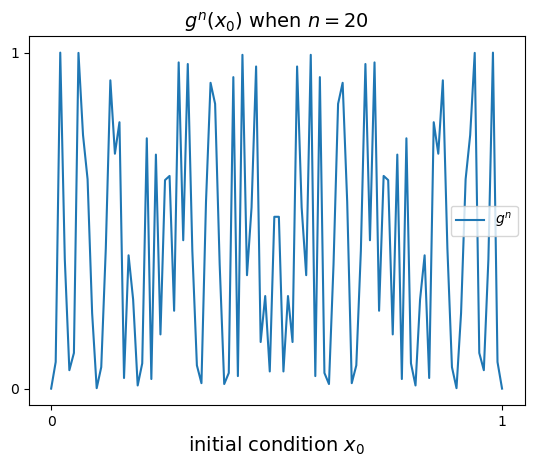

In [31]:
plot_gn()

In [32]:
def plot_traj():
    fig, ax = plt.subplots()
    ax.plot(gen_trajectory(0.3, n=150), 'o-', alpha=0.6)
    ax.set_xlabel("$t$", fontsize=14)
    ax.set_ylabel("$x_t$", fontsize=14)
    ax.set_yticks((0, 1))
    ax.set_xticks((0, 50, 100, 150))
    plt.show()

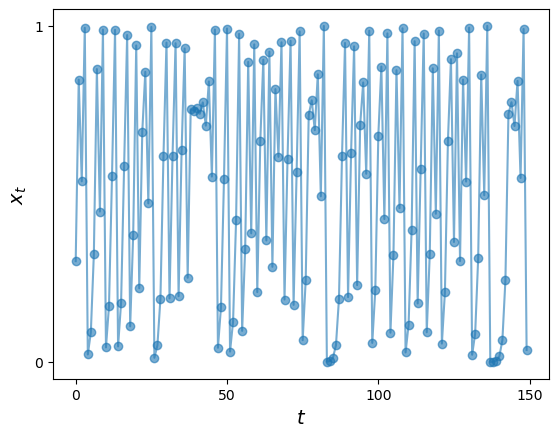

In [33]:
plot_traj()

In [34]:
def plot_traj_hist():
    fig, ax = plt.subplots()
    ax.hist(gen_trajectory(0.3, n=100_000), **kwargs, label='observations')
    ax.set_xlabel("state", fontsize=14)
    ax.set_ylabel("frequency", fontsize=14)
    ax.set_ylim(0, 6)
    ax.legend()
    plt.show()

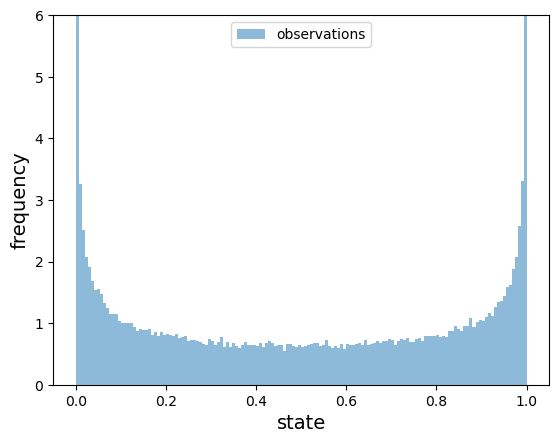

In [35]:
plot_traj_hist()

In [36]:
def plot_traj_hist_and_stationary():
    fig, ax = plt.subplots()
    ax.hist(gen_trajectory(0.3, n=250_000), **kwargs, label='observations')
    y_vals = f_star(x_grid)
    ax.plot(x_grid, y_vals, label='$\psi^*$')
    ax.set_xlabel("state", fontsize=14)
    ax.set_ylabel("frequency", fontsize=14)
    ax.set_ylim(0, 6)
    ax.legend()
    plt.show()

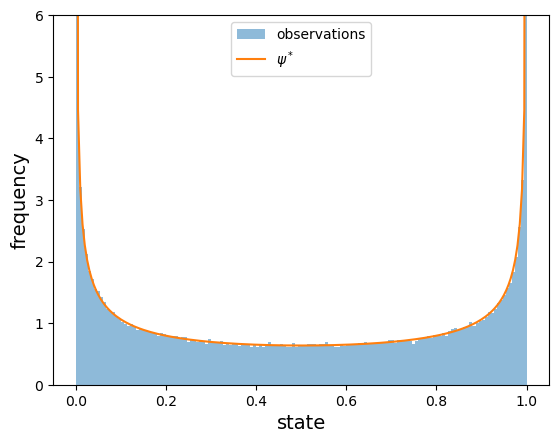

In [37]:
plot_traj_hist_and_stationary()

In [38]:
def plot_dist_images():

    def plot_data(ax, y_data, hist_data, label):
        ax.set_xlim(-0.05, 1.05)
        ax.set_ylim(-0.1, 4.05)
        ax.set_yticks([])
        ax.set_xticks((0, 1))
        ax.set_title("time zero distribution")
        ax.plot(x_grid, y_data, label=label)
        ax.hist(hist_data, **kwargs, color='orange')
        ax.legend(loc='upper center')

    sample_size = 100_000

    fig, axes = plt.subplots(3, 2, figsize=(10, 6.6))
    
    beta_param_set = (2, 2), (2, 5), (5, 2)
    for i, beta_params in enumerate(beta_param_set):
        f0 = np.random.beta(*beta_params, size=sample_size)
        fT = g_shifter(f0)
        q = beta(*beta_params)
        y_data = q.pdf(x_grid)
        plot_data(axes[i, 0], q.pdf(x_grid), f0, "$\psi_0$")
        plot_data(axes[i, 1], f_star(x_grid), fT, "$\psi^*$")

    fig.tight_layout()
    plt.show()

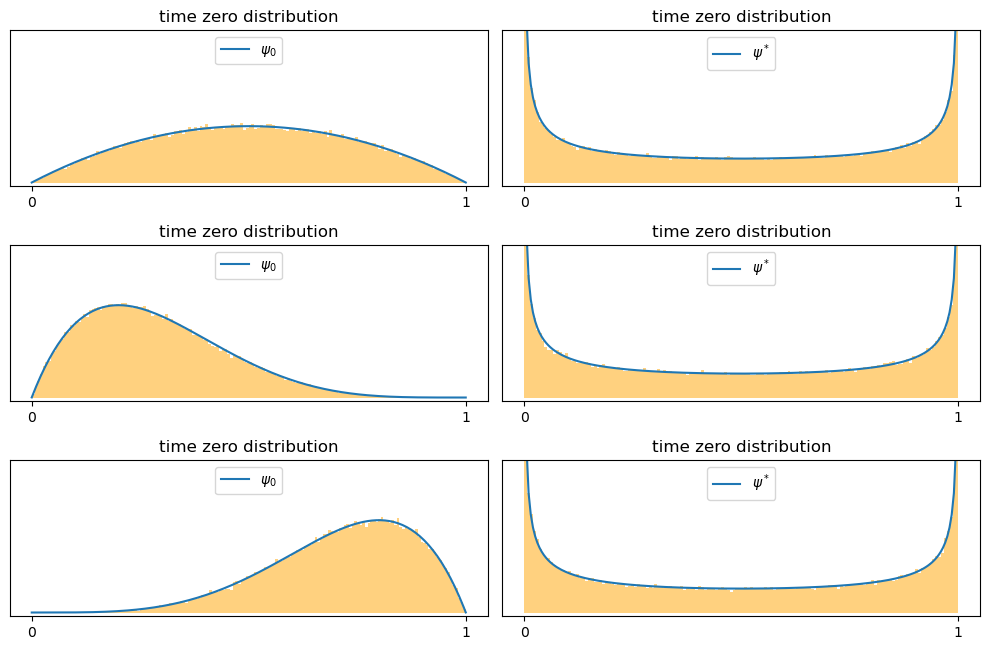

In [39]:
plot_dist_images()

## Speed test

In [147]:
def update(x):
    return 4.0 * x * (1 - x)

In [148]:
def g_shifter_loop(x, n):
    " Shift x0 forward n periods. "
    for _ in range(n):
        x = update(x)
    return x

In [149]:
g_shifter = jax.jit(g_shifter_loop, static_argnums=(1,))

In [154]:
m = 10_000_000
n = 100

key = jax.random.PRNGKey(1234)
x0 = jax.random.uniform(key, (m,))

In [155]:
%time jax_out = g_shifter(x0, n).block_until_ready()

CPU times: user 1.58 ms, sys: 229 µs, total: 1.81 ms
Wall time: 15.8 ms


In [158]:
%time jax_out = g_shifter(x0, n).block_until_ready()

CPU times: user 1.86 ms, sys: 277 µs, total: 2.13 ms
Wall time: 15.9 ms
